<a href="https://__plb__.gitlab.io/3pmpols6-cours/" target="_blank">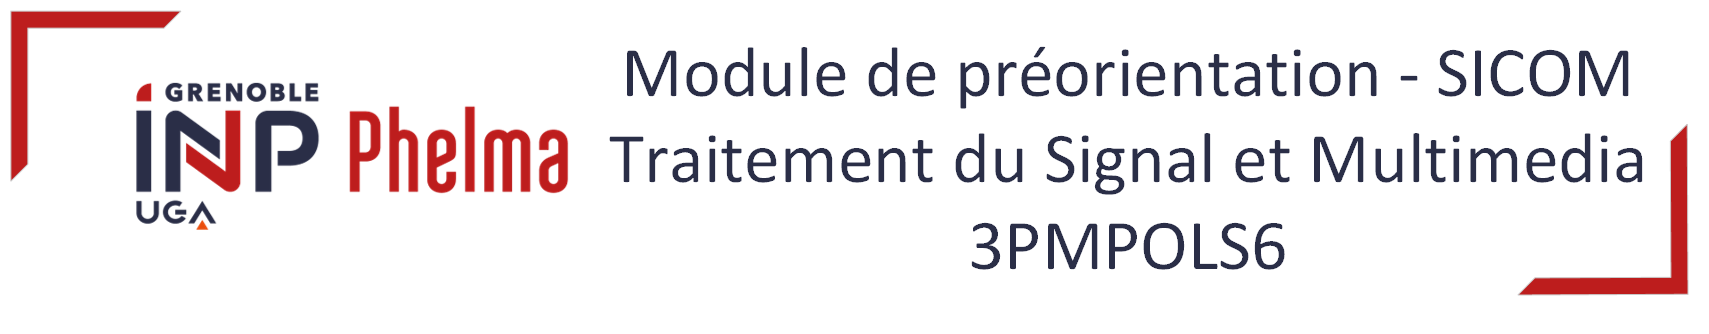</a>

# TD 2 - Partie 1

**Objectifs de ce TD :**

- 🧠 Comprendre le fonctionnement des réseaux de neurones **denses** sur les images
- ⚖️ Comprendre les poids appris par le réseau de neurones **dense** lors de la phase d'entrainement
___

## Préparation : mise en place de l'environnement de travail du TD

Cette **phase préparatoire** se déroule en deux temps :

1. **Importation des bibliothèques** Python nécessaires pour le TD

💻 *Exécuter le code de la cellule et vérifier qu'il n'y a pas d'erreurs. Un message de warning doit apparaître. A quoi correspond ce message ?*



In [ ]:
# Importation des bibliothèques Python nécessaires au TD
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from PIL import Image
import matplotlib.pyplot as plt
import random
import ipywidgets as widgets
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2. **Création des fonctions** pour générer les **images utilisées** pour le TD

💻 *Exécuter le code de la cellule*

In [ ]:
def create_seven_segment_display(number=0, sigma=1, norm=True):
    image = np.zeros((28, 28)) # Image noir de fond
    # Position des segments sur l'image
    segments = {
        'a': [(max(0, round(random.gauss(2, sigma))), i) for i in range(7, 21)],
        'b': [(i, min(27, round(random.gauss(22, sigma)))) for i in range(3, 13)],
        'c': [(i, min(27, round(random.gauss(22, sigma)))) for i in range(15, 25)],
        'd': [(min(27, round(random.gauss(25, sigma))), i) for i in range(7, 21)],
        'e': [(i, max(0, round(random.gauss(5, sigma)))) for i in range(15, 25)],
        'f': [(i, max(0, round(random.gauss(5, sigma)))) for i in range(3, 13)],
        'g': [(max(0, min(27, round(random.gauss(13, sigma)))), i) for i in range(7, 21)],
    }
    # Liste des positions des segments pour les valeurs héxadécimales
    digits = [
        "abcdef", "bc", "abged", "abgcd", "fgbc",
        "afgcd", "afgcde", "fabc", "abcdefg", "abcdfg",
        "efabcg", "fedcg", "afed", "bcdeg", "afged",
        "afge",
    ]
    # Création du chiffre choisi dans le paramètre "number"
    for seg in [segments[dig] for dig in digits[number]]:
        for y, x in seg:
            if norm is True:
                image[y, x] = 1
            else:
                image[y, x] = 255
    return image

def create_dataset(nb_train=6000, nb_test=1000, val=(3, 15), sigma=1, all_nb=False, norm=True):
    X_train, y_train, X_test, y_test = [], [], [], []
    # Toutes les valeurs hexadicémales (suppression des deux valeurs par défaut)
    if all_nb is True:
        val = range(0, 10)
    for _ in range(nb_train):
        for digit in val:
            X_train.append(create_seven_segment_display(digit, sigma, norm=norm))
            if all_nb is True:
                y_train.append(digit)
            else:
                y_train.append(0 if digit==val[0] else 1)
    for _ in range(nb_test):
        for digit in val:
            X_test.append(create_seven_segment_display(digit, sigma, norm=norm))
            if all_nb is True:
                y_test.append(digit)
            else:
                y_test.append(0 if digit==val[0] else 1)
    return (np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test))

___

## Manipulation 1 : exemple simple de l'afficheur 7 segments

<figure>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ed/7_Segment_Display_with_Labeled_Segments.svg/800px-7_Segment_Display_with_Labeled_Segments.svg.png" style="height:200px;">

  <figcaption>
    Les 7 segments sont désignés par des lettres sur l'afficheur (source <a href="https://fr.wikipedia.org/wiki/Affichage_à_sept_segments" target="_blank">wikipédia</a>)
  </figcaption>
</figure>

### *🎯 Objectif de cette partie :* comprendre comment un **réseau de neurones dense** apprend le contenu d'une image sur des **exemples simples**

### Création des images
💻 *Exécuter le code de la cellule en **testant différentes valeurs** des paramètres `val` et `sigma`. Le paramètre `val` définit les deux valeurs de caractère hexadicémal à afficher sur l'image. Le paramètre `sigma` définit l'écart-type de la distribution gaussienne de variation de la position des points qui forment l'afficheur 7 segments*

In [ ]:
val = (1, 8)

(x_train, y_train, x_test, y_test) = create_dataset(val=val, sigma=.1, all_nb=False)
fig, axs = plt.subplots(1, 10, figsize=(15, 15))
for i in range(10):
    axs[i].imshow(x_train[i], cmap='gray')
    axs[i].axis('off')
plt.show()

### Définition et entrainement du modèle

💻 Exécuter le code de la cellule pour créer le modèle dense. Quelle est l'architecture du réseau de neurones ?

In [ ]:
def fcn(input_shape=(28, 28, 1), output=1, activation="sigmoid"):
    """
    Création du réseau de neurones complétement connecté
    """
    print("Réseau dense")
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Flatten(name="Couche_entree"),
            layers.Dense(output, activation=activation, name="Couche_sortie"),
        ]
    )
    print(model.summary())
    return model



def train_evaluate(model, x_train, y_train, x_test, y_test, loss="binary_crossentropy", epochs=10):
    """
    Entrainement et évaluation du modèle
    """
    model.compile(loss=loss, optimizer="adam", metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_split=0.1)
    score = model.evaluate(x_test, y_test, verbose=0)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])
    return score[1]



def evaluate(model, x_test, y_test):
    """
    Evaluation du modèle
    """
    score = model.evaluate(x_test, y_test, verbose=0)
    print("Test accuracy:", score[1]*100, "%")
    return score[1]

💻 Exécuter le code pour entrainer le modèle. Analyser le résultat et expliquer le nombre de paramètres du modèle

In [ ]:
model = fcn(output=1, activation="sigmoid")
test_acc_fcn = train_evaluate(model, 
                              x_train, y_train, 
                              x_test, y_test)

### Analyse des performances et des poids du modèle
💻 *Exécuter le code pour analyser les performances du modèle*

In [ ]:
y_pred = model.predict(x_test)

predicted_categories = y_pred>.5
true_categories      = y_test

cm_fcn = confusion_matrix(true_categories, predicted_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_fcn,
                              display_labels=val)


evaluate(model, x_test, y_test)
disp.plot()

💻 Exécuter le code et analyser les **poids du neurone** de la couche de sortie

In [ ]:
# Extraire les poids de la première couche dense
weights = model.layers[1].get_weights()[0]
weights_reshaped = weights.reshape(28, 28, -1)

# Créer le graphique 3D avec une surface colorée
fig = go.Figure(data=[go.Surface(
    z=weights_reshaped[:,:,0],
)])

fig.update_layout(
    title='Poids du neurone de la couche de sortie',
    scene_xaxis_autorange="reversed",
    scene=dict(zaxis=dict(range=[-1,1])),
    width=800,  # Largeur en pixels
    height=600,  # Hauteur en pixels
)

fig.show()


print(f'Représentation statique des poids du neurone de la couche de sortie')
im = plt.imshow(weights_reshaped[:, :, 0], cmap='gray')
plt.colorbar(im, orientation='vertical')
plt.axis('off')
plt.show()

___

## Manipulation 2 : exemple un peu plus compliqué avec les 10 chiffres de l'afficheur 7 segments



### Création des images des bases d'apprentissage et de test
*💻 Exécuter le code de la cellule pour créer les images des 10 chiffres

In [ ]:
num_classes = 10

(x_train_10classes, y_train_10classes, x_test_10classes, y_test_10classes) = create_dataset(sigma=.1, all_nb=True)

y_train_10classes = keras.utils.to_categorical(y_train_10classes, num_classes)
y_test_10classes = keras.utils.to_categorical(y_test_10classes, num_classes)

fig, axs = plt.subplots(1, 10, figsize=(15, 15))
for i in range(10):
    axs[i].imshow(x_train_10classes[i], cmap='gray')
    axs[i].axis('off')
plt.show()

### Définition et apprentissage du modèle
💻 Exécuter le code de la cellule pour créer le modèle dense. Quelle est l'architecture du réseau de neurones ?

In [ ]:
model_10classes = fcn(output=10, activation="softmax")
result_10classes = train_evaluate(model_10classes, 
                                  x_train_10classes, y_train_10classes, 
                                  x_test_10classes, y_test_10classes, 
                                  loss="categorical_crossentropy",
                                  epochs=10)

### Analyse des performances et des poids du modèle
💻 *Exécuter le code pour analyser les performances du modèle*

In [ ]:
y_pred_10classes = model_10classes.predict(x_test_10classes)

predicted_categories_10classes = np.argmax(y_pred_10classes, axis=1)
true_categories_10classes      = np.argmax(y_test_10classes, axis=1)

cm_fcn_10classes = confusion_matrix(true_categories_10classes, predicted_categories_10classes, 
                          labels=np.arange(0,10))
disp_10classes = ConfusionMatrixDisplay(confusion_matrix=cm_fcn_10classes,
                              display_labels=np.arange(0,10))


evaluate(model_10classes, x_test_10classes, y_test_10classes)
disp_10classes.plot()

💻 Exécuter le code et analyser les **poids du neurone** de la couche de sortie

In [ ]:
# Extraire les poids de la première couche dense
weights_fcn_10classes = model_10classes.layers[1].get_weights()[0]
weights_reshaped_fcn_10classes = weights_fcn_10classes.reshape(28, 28, -1)

# Fonction pour mettre à jour le graphique
def update_plot(neuron_index):

    print(f"Exemples de données d'entrainement pour le chiffre {neuron_index}")
    # Afficher 10 images
    fig, axs = plt.subplots(1, 10, figsize=(15, 15))
    count = 0
    for i in range(1000):
        if y_train_10classes[i].argmax()==neuron_index:
            axs[count].imshow(x_train_10classes[i], cmap='gray')
            axs[count].axis('off')
            count += 1
        if count==10:
            break
    plt.show()
    
    fig = go.Figure(data=[go.Surface(
        z=weights_reshaped_fcn_10classes[:, :, neuron_index],
    )])

    fig.update_layout(
        title=f'Poids du neurone {neuron_index} de la couche de sortie',
        scene_xaxis_autorange="reversed",
        scene=dict(zaxis=dict(range=[-1,1])),
        width=800,
        height=600,
    )
    
    fig.show()

    print(f'Représentation statique des poids du neurone {neuron_index} de la couche de sortie')
    im=plt.imshow(weights_reshaped_fcn_10classes[:, :, neuron_index], cmap='gray')
    plt.colorbar(im, orientation='vertical')
    plt.axis('off')
    plt.show()

# Création de la liste déroulante
neuron_selector = widgets.IntSlider(
    value=0,
    min=0,
    max=9,
    step=1,
    description='Neurone:',
    continuous_update=False
)

# Interactivité
widgets.interactive(update_plot, neuron_index=neuron_selector)

___

## Manipulation 3 : exemple un peu plus compliqué avec des chiffres manuscrits (MNIST)

<figure>
    <img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png" style="height:200px;">
  <figcaption>
    Base de données MNIST (source <a href="https://fr.wikipedia.org/wiki/Base_de_donn%C3%A9es_MNIST" target="_blank">wikipédia</a>)
  </figcaption>
</figure>

Le jeu de données <a href="https://fr.wikipedia.org/wiki/Base_de_donn%C3%A9es_MNIST" target="_blank">**MNIST**</a> est un **ensemble de données** très utilisé pour débuter en **vision par ordinateur**.

*💻 Exécuter le code de la cellule et comparer les images avec celles de la partie précédente*

In [ ]:
# Charger les données MNIST
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()

# Normaliser les données
x_train_mnist = x_train_mnist / 255.0
x_test_mnist = x_test_mnist / 255.0

# Convertir les étiquettes en catégories
y_train_mnist = to_categorical(y_train_mnist, 10)
y_test_mnist = to_categorical(y_test_mnist, 10)

# Afficher 10 images
fig, axs = plt.subplots(1, 10, figsize=(15, 15))
for i in range(10):
    axs[i].imshow(x_train_mnist[i], cmap='gray')
    axs[i].axis('off')
plt.show()

*💻 Exécuter le code de la cellule et comparer avec l'entrainement de la première partie*

In [ ]:
model_mnist = fcn(output=10, activation="softmax")
result_mnist = train_evaluate(model_mnist, 
                              x_train_mnist, y_train_mnist, 
                              x_test_mnist, y_test_mnist, 
                              loss="categorical_crossentropy")

💻 *Exécuter le code pour analyser les performances du modèle*

In [ ]:
y_pred_mnist = model_mnist.predict(x_test_mnist)

predicted_categories_mnist = np.argmax(y_pred_mnist, axis=1)
true_categories_mnist      = np.argmax(y_test_mnist, axis=1)

cm_fcn_mnist = confusion_matrix(true_categories_mnist, predicted_categories_mnist, 
                          labels=np.arange(0,10))
disp_mnist = ConfusionMatrixDisplay(confusion_matrix=cm_fcn_mnist,
                              display_labels=np.arange(0,10))


evaluate(model_mnist, x_test_mnist, y_test_mnist)
disp_mnist.plot()

*💻 Exécuter le code de la cellule et analyser le résultats pour les **10 neurones de la couche de sortie***

In [ ]:
# Extraire les poids de la première couche dense
weights_mnist = model_mnist.layers[1].get_weights()[0]
weights_reshaped_mnist = weights_mnist.reshape(28, 28, -1)


def update_plot(neuron_index):
    """Fonction pour mettre à jour le graphique"""
    # Afficher 10 images
    print(f"Exemples de données d'entrainement pour le chiffre {neuron_index}")
    fig, axs = plt.subplots(1, 10, figsize=(15, 15))
    count = 0
    for i in range(1000):
        if y_train_mnist[i].argmax()==neuron_index:
            axs[count].imshow(x_train_mnist[i], cmap='gray')
            axs[count].axis('off')
            count += 1
        if count==10:
            break
    plt.show()
    
    fig = go.Figure(data=[go.Surface(
        z=weights_reshaped_mnist[:, :, neuron_index],
    )])

    fig.update_layout(
        title=f'Poids du neurone {neuron_index} de la couche de sortie',
        scene_xaxis_autorange="reversed",
        scene=dict(zaxis=dict(range=[-1,1])),
        width=800,
        height=600,
    )
    fig.show()

    print(f'Représentation statique des poids du neurone {neuron_index} de la couche de sortie')
    plt.imshow(weights_reshaped_mnist[:, :, neuron_index], cmap='gray')
    plt.axis('off')
    plt.show()

# Création de la liste déroulante
neuron_selector = widgets.IntSlider(
    value=0,
    min=0,
    max=9,
    step=1,
    description='Neurone:',
    continuous_update=False
)

# Interactivité
widgets.interactive(update_plot, neuron_index=neuron_selector)

<a href="https://phelma.grenoble-inp.fr" target="_blank">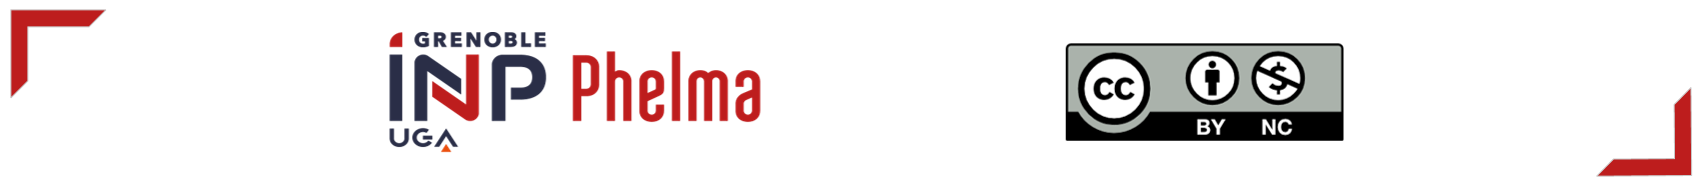</a>